# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
##Setup the google drive items to read files
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
##Load the required libraries
#Added incrementaly

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Reshape, Conv2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
import matplotlib.patches as patches
import cv2

### Change directory

In [3]:
#Change the directory to read the input data
#define the paths for ease of use later
data_path = "/content/drive/My Drive/GL_Colab/ACV"
image_location = data_path + "/images/"

#Change the directory
os.chdir(data_path)

In [4]:
#check if we have the data files
!ls -l

total 26752
-rw------- 1 root root    28053 Sep 12 14:19  Bounding_Box_Class_version.ipynb
drwx------ 3 root root     4096 Apr 22  2019  images
-rw------- 1 root root 26574193 Sep 12 09:36  images_racoon.rar
-rw------- 1 root root     9639 Sep 12 10:56 'orig_R9 - ACV - Internal_Lab_Questions.ipynb'
-rw------- 1 root root   768691 Sep 13 06:08  Residency10_Internal_Lab_V1.0.ipynb
-rw------- 1 root root     7913 Sep 12 09:36  train_labels.csv


In [5]:
##See if we can unrar the images
!pip install unrar
!unrar x "./images_racoon.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ./images_racoon.rar


Would you like to replace the existing file images/images/raccoon-1.jpg
 58076 bytes, modified on 2019-04-15 23:51
with a new one
 58076 bytes, modified on 2019-04-15 23:51

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit ALL

Extracting  images/images/raccoon-1.jpg                                    0%  OK 
Extracting  images/images/raccoon-10.jpg                                   0%  OK 
Extracting  images/images/raccoon-100.jpg                                  0%  OK 
Extracting  images/images/raccoon-101.jpg                                  1%  OK 
Extracting  images/images/raccoon-102.jpg                                  1%  OK 
Extracting  images/images/raccoon-103.jpg                                  2%  OK 
Extracting  images/images/raccoon-104.jpg                                  2%  OK 
Extracting  images/image

### Load the training data from train.csv file

In [6]:
#Read rows from train_labels.csv to check the data values
#We will read the full data below
train_labels = pd.read_csv(data_path + "/train_labels.csv")

In [7]:
#sanity check
train_labels.sample()

,filename,width,height,class,xmin,ymin,xmax,ymax
66,raccoon-117.jpg,640,448,raccoon,100,124,266,324


In [8]:
#check the dataset summary
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  173 non-null    object
 1   width     173 non-null    int64 
 2   height    173 non-null    int64 
 3   class     173 non-null    object
 4   xmin      173 non-null    int64 
 5   ymin      173 non-null    int64 
 6   xmax      173 non-null    int64 
 7   ymax      173 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 10.9+ KB


### Print the shape of the train dataset

In [9]:
#Check the shape of the label dataset...indicates the available data
train_labels.shape

#This indicates that we have 173 training records each having 8 data elements

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [10]:
#Static variables and information
IMAGE_SIZE = 128 #Size of input image will be 128x128 for mobilenet

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in individual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [11]:
#Read the training data for use later in appropriate format
#the format of the records is filename,width, height, class name, xmin,ymin,xmax,ymax

with open(data_path + "/train_labels.csv") as inputfile:
  paths = [] #initialize the list for storing the paths of individual images
  coords = np.zeros((sum(1 for line in inputfile) - 1 , 4)) #store the bounding box co-ordinates for each record. ensure we skip the header count
  reader = csv.reader(inputfile, delimiter=',',)  #initialize the csvreader
  inputfile.seek(0) #go to the first record
  next(reader, None)  # skip the headers


  for record_id, eachrow in enumerate(reader):
    #print(record_id,eachrow)

    #print(eachrow)
    relevant_indices = [1,2,4,5,6,7] #Just pick what we want
    relevant_values = [int(eachrow[value]) for value in relevant_indices] #convert to int for use in calculations
    #print(relevant_values)
    image_width, image_height, x0, y0, x1, y1 = relevant_values
    
    coords[record_id, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[record_id, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
    coords[record_id, 2] = x1 * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[record_id, 3] = y1 * IMAGE_SIZE / image_height # Normalize bounding box by image size

    #Add the the paths to the path list
    path = eachrow[0] #extract the raw filename
    path = image_location + path #Fully qualified path
    #print(path)
    paths.append(path)

In [12]:
#sanity
coords.shape

(173, 4)

In [13]:
coords[3]

array([48.42666667, 29.76      , 85.97333333, 95.36      ])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [14]:
##Read the images and load it for training
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32) #intialize based on no of samples

#read each file
for i, fname in enumerate(paths):
  #print(f)
  img = Image.open(fname) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB') #convert to RGB 3 channel for use in mobilenet
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) #do the preprocessing needed for mobilenet before saving


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


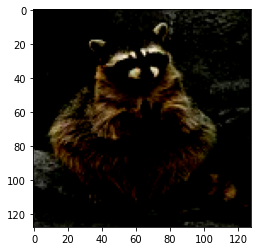

In [15]:
#sanity
plt.imshow(batch_images[5])

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [16]:
#alpha is used to control the mobilenet architecture
ALPHA = 1.0 # Width hyper parameter for MobileNet. We will go with the standard width

#Load the pretrained mobilenet model without the top layer
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet

#freeze all the layers
for layer in model.layers:
    layer.trainable = False


# Add new conv layer to get 4 o/ps
x = model.layers[-1].output #last layers output to be used for input to our new layer
x = Conv2D(4, kernel_size=4, name="custom_layer1")(x)
#Reshape to 4 values
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [17]:
#check the model summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [18]:
gt = coords #Copy over the training coordinates as the ground truth
def loss(gt,pred):
    #print(gt,pred)
    
    intersections = 0
    unions = 0
    #calculate the areaa of intersection and individual boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    #print("Union",union)

    #Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32) #Ensure the function works in tensorflow
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [19]:
#Compile the model
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

In [20]:
#Set the epochs and batch size
EPOCHS = 30
BATCH_SIZE = 32

In [21]:
#Start training the model in verbose model
model.fit(batch_images,coords,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1)

Epoch 1/30
6/6 [==============================] - 2s 279ms/step - loss: 4163.1519 - IoU: 0.0873
Epoch 2/30
6/6 [==============================] - 2s 278ms/step - loss: 826.2684 - IoU: 0.4158
Epoch 3/30
6/6 [==============================] - 2s 284ms/step - loss: 446.3215 - IoU: 0.5799
Epoch 4/30
6/6 [==============================] - 2s 282ms/step - loss: 599.5370 - IoU: 0.5286
Epoch 5/30
6/6 [==============================] - 2s 280ms/step - loss: 352.0129 - IoU: 0.6323
Epoch 6/30
6/6 [==============================] - 2s 289ms/step - loss: 198.5475 - IoU: 0.6609
Epoch 7/30
6/6 [==============================] - 2s 281ms/step - loss: 199.6632 - IoU: 0.6624
Epoch 8/30
6/6 [==============================] - 2s 288ms/step - loss: 162.0298 - IoU: 0.6873
Epoch 9/30
6/6 [==============================] - 2s 282ms/step - loss: 126.9582 - IoU: 0.7405
Epoch 10/30
6/6 [==============================] - 2s 283ms/step - loss: 116.3257 - IoU: 0.7651
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [22]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = image_location + "raccoon-7.jpg"
#print(filename)
test_image = cv2.imread(filename) #read the image

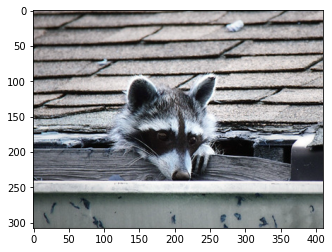

In [23]:
#Sanity check
plt.imshow(test_image)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [24]:
#same preprocessing as the training
image_height, image_width, _ = test_image.shape #extract cuttent shape for use later
scaled_image = cv2.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image
preprocessed_test_image = preprocess_input(np.array(scaled_image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [25]:
#Get the predictions from the model for this image
region = model.predict(x=np.array([preprocessed_test_image]))[0] 

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

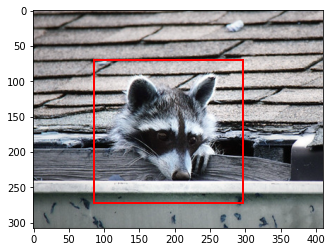

In [26]:
#We will first rescale the box coordinates to the actual image size

x0 = int(region[0] * image_width / IMAGE_SIZE) 
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the original test image
ax.imshow(test_image)

# Draw the box using patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [27]:
##We can see in random attempts that for some test images the box is very close but for few others it is bit way off. 
##We could train the model for some more epochs to see if it makes a difference

In [28]:
###Lets try for an image not seen in training at all
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = image_location + "test_image.jpg"
#print(filename)
test_image = cv2.imread(filename) #read the image

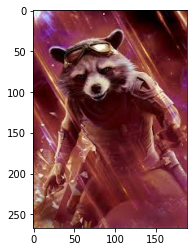

In [29]:
#Sanity check
plt.imshow(test_image)

In [30]:
#same preprocessing as the training
image_height, image_width, _ = test_image.shape #extract cuttent shape for use later
scaled_image = cv2.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image
preprocessed_test_image = preprocess_input(np.array(scaled_image, dtype=np.float32))

In [31]:
#Get the predictions from the model for this image
region = model.predict(x=np.array([preprocessed_test_image]))[0] 

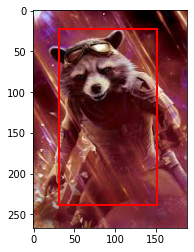

In [32]:
#We will first rescale the box coordinates to the actual image size

x0 = int(region[0] * image_width / IMAGE_SIZE) 
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the original test image
ax.imshow(test_image)

# Draw the box using patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [33]:
#The model did a decent job for this new image as well